In [727]:
## Josh Blaz -- LOTR
## CS401 -- NLP

import nltk
import re
import urllib.request
import lxml.html as lh
import io
import requests
import os
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from collections import Counter 
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import wordnet as wn

#NOTE: Sentiment140 Polarity values: 0: negative, 2: neutral, 4: positive

#### NOTE: Elvish text is translated awkwardly into the .txt format    
</br>
##### IE:   
</br>
►M MPR -F+MTRX MP ft PPtK P&RMPht: P. t. The last Two runes are the initials of Thror and Thrain.**  
</br>
#### Same with some of the intros:
</br>
“THE LORD OF THE RINGS” 

Pjrt Thttt 

THE RETURN 
OF THE KING 


In [682]:
## Get all tokens

## --- The Silmarillion ---
silm_file = open('silmarillion.txt', 'r')
silm = silm_file.read() 
silm_raw = silm[43190:-5436] ## save raw files for later
silm = silm.lower() ## Make all words lowercase 
silm = silm[43190:-5436] ## remove HTML jargon
silm = nltk.word_tokenize(silm) ## tokenize

## --- The Hobbit ---
hobbit_file = open('hobbit.txt', 'r')
hobbit = hobbit_file.read()
hobbit_raw = hobbit[43212:-8543]
hobbit = hobbit.lower()
hobbit = hobbit[43212:-8543]
hobbit = nltk.word_tokenize(hobbit)

## --- The Fellowship of the Ring ---
fellowship_file = open('fellowship.txt', 'r')
fellowship = fellowship_file.read()
fellowship_raw = fellowship[43242:-5436]
fellowship = fellowship.lower()
fellowship = fellowship[43242:-5436]
fellowship = nltk.word_tokenize(fellowship)

## --- The Two Towers ---
twotowers_file = open('twotowers.txt', 'r')
twotowers = twotowers_file.read()
twotowers_raw = twotowers[43302:-19245]
twotowers = twotowers.lower()
twotowers = twotowers[43302:-19245]
twotowers = nltk.word_tokenize(twotowers)

## --- The Return of the King ---
ret_file = open('return.txt', 'r')
ret = ret_file.read()
ret_raw = ret[43252:-5434]
ret = ret.lower()
ret = ret[43252:-5434]
ret = nltk.word_tokenize(ret)

tokenlist = [silm, hobbit, fellowship, twotowers, ret]

raw_texts = [silm_raw, hobbit_raw, fellowship_raw, twotowers_raw, ret_raw] #Text files to use with LDA topic modeling


entirety = [] ## This is all tokens combined
for i in range(len(tokenlist)):
    for word in tokenlist[i]:
        entirety.append(word)

In [683]:
# Used Chapterize to split books into chapters 
## https://github.com/JonathanReeve/chapterize
### Chapterize didn't work 100% perfectly, so I had to go through and the prologues back in when it cut them out

# These are lists containing strings of every chapter for each book
silm_chapters = []
hobbit_chapters = []
fellowship_chapters = []
twotowers_chapters = []
return_chapters = []

# Paths to directories storing book chapters
list_of_paths = ['/Users/blaz/Desktop/LOTR/silmarillion-chapters', '/Users/blaz/Desktop/LOTR/hobbit-chapters',\
                '/Users/blaz/Desktop/LOTR/fellowship-chapters', '/Users/blaz/Desktop/LOTR/twotowers-chapters',\
                '/Users/blaz/Desktop/LOTR/return-chapters']

for path in list_of_paths: # iterate through the list of folder paths for each book
    for file in sorted(glob.glob(os.path.join(path,'*.txt'))): # This gives us a sorted list of the files in each directory                                                         
        f = open(file, 'r') # open and read file               # allowing us to read in the chapters in order.
        txt = f.read()
        ## determine which path we're using and append it to the correct book chapter list
        if path == '/Users/blaz/Desktop/LOTR/silmarillion-chapters': 
            # Because of an issue with 'glob', I had to create a copy of the final chapter in The Silmarillion
            silm_chapters.append(txt)
        elif path == '/Users/blaz/Desktop/LOTR/hobbit-chapters':
            hobbit_chapters.append(txt)
        elif path == '/Users/blaz/Desktop/LOTR/fellowship-chapters': 
            fellowship_chapters.append(txt)
        elif path == '/Users/blaz/Desktop/LOTR/twotowers-chapters': 
            twotowers_chapters.append(txt)
        elif path == '/Users/blaz/Desktop/LOTR/return-chapters': 
            return_chapters.append(txt)

In [684]:
# Store chapter names for use in dataframes later

silm_chapter_names = ["Ainundalë", "Valaquenta", "Of the Beginning of Days", "Of Aulë and Yavanna" , "Of the Coming of the Elves and the Captivity of Melkor",\
                     "Of Thingol and Melian", "Of Eldamar and the Princes of the Eldalië", "Of Fëanor and the Unchaining of Melkor", "Of the Silmarils and the Unrest of the Noldor",\
                     "Of the Darkening of Valinor", "Of the Flight of the Noldor", "Of the Sindar", "Of the Sun and Moon and the Hiding of Valinor", "Of Men", "Of the Return of the Noldor",\
                     "Of Beleriad and its Realms", "Of the Noldor in Beleriad", "Of Maeglin", "Of the Coming of Men into the West", "Of the Ruin of Beleriad and the Fall of Fingolfin", "Of Beren and Lúthien",\
                     "Of the Fifth Battle: Nirnaeth Arnoediad", "Of Túrin Turambar", "Of the Ruin of Doriath", "Of Tuor and the Fall of Gondolin", "Of the Voyage of Eärendil and the War of Wrath", \
                     "Akallabêth: The Downfall of Númenor", "Of the Rings of Power and the Third Age"]

hobbit_chapter_names = ["An Unexpected Party", "Roast Mutton", "A Short Rest", "Over Hill and Under Hill", "Riddles In The Dark", \
                       "Out Of The Frying-Pan Into The Fire", "Queer Lodgings", "Flies And Spiders", "Barrels Out Of Bond", "A Warm Welcome", \
                       "On The Doorstep", "Inside Information", "Not At Home", "Fire And Water", "The Gathering Of The Clouds", "A Thief In The Night", \
                       "The Clouds Burst", "The Return Journey", "The Last Stage"]

fellowship_chapter_names = ["Concerning Hobbits", "Concerning Pipeweed", "Of the Ordering of the Shire", "Note on the Shire Records", "A Long-expected Party", "The Shadow of the Past", \
                           "Three is Company", "A Short Cut to Mushrooms", "A Conspiracy Unmasked", "The Old Forest", "In the House of Tom Bombadil", "Fog on the Barrow-downs", "At the Sign of the Prancing Pony",\
                           "Strider", "A Knife in the Dark", "Flight to the Ford", "Many Meetings", "The Council of Elrond", "The Ring goes South", "A Journey in the Dark", "The Bridge of Khazad-dûm", \
                           "Lothlórien", "The Mirror of Galadriel", "Farewell to Lórien", "The Great River", "The Breaking of the Fellowship"]

twotowers_chapter_names = ["The Departure of Boromir", "The Riders of Rohan", "The Uruk-hai", "Treebeard", "The White Rider", "The King of the Golden Hall", "Helm's Deep", "The Road to Isengard", "Flotsam and Jetsam", \
                          "The Voice of Saruman", "The Palantír", "The Taming of Smeagol", "The Passage of the Marshes", "The Black Gate is Closed", "Of Herbs and Stewed Rabbit", "The Window of the West", "The Forbidden Pool", \
                          "Journey to the Cross-roads", "The Stairs to Cirith Ungol", "Shelob's Lair", "The Choices of Master Samwise"]

return_chapter_names = ["Minas Tirith", "The Passing of the Grey Company", "The Muster of Rohan", "The Siege of Gondor", "The Ride of Rohirrim", "The Battle of the Pelennor Fields", "The Pyre of Denethor",\
                       "The Houses of Healing", "The Last Debate", "The Black Gate Opens", "The Tower of Cirith Ungol", "The Land of Shadow", "Mount Doom", "The Field of Cormallen", "The Steward and the King", \
                       "Many Partings", "Homeward Bound", "Scouring of the Shire", "The Grey Havens"]

chapter_name_list = [silm_chapter_names, hobbit_chapter_names, fellowship_chapter_names, twotowers_chapter_names, return_chapter_names]

# Sentiment Analysis


### ** 1. Segment all chapters into page-sized objects    **    
</br>
### ** 2. Send all segments to Sentiment140 API by chapter    **   
</br>
### ** 3. Calculate polarity averages and polarity lists. **   
</br>
### ** 4. Store API polarity ratings and export to csv**
</br>
### ** 5. Plot all polarities + Averages**       

In [685]:
"""
Function that segments given chapter into n-sized segments to be sent to the API.
Typically using n=2940, as this is the #chars in my copy of Fellowship of the Ring.

Parameters - chapter - chapter of a book to be broken into segments
           - n - length that we segment the text with
       
Returns a list of (string) segments of the chapter.
"""
def Segmenter(chapter, n):
    segments = []
    # start and end indices for segmenting the text
    start = 0
    end = n
    while end < len(chapter) + n:
        segments.append(chapter[start:end])
        start = end
        end = end + n
    return segments #segments of input chapter

In [687]:
# Goal:
# Create lists of lists for segments of each chapter of each book, append to them using "Segmenter" function, 
# storing them like this will allow for iterative querying of the API server


# Lists of Lists of Lists storing all segments of all chapters for each book
# [[chapter1 segment 0-2500, chap1, segmenet 2500-5000]... [chapter2 segment0-2500, ...]...]
silm_segments = []
hobbit_segments = []
fellowship_segments = []
twotowers_segments = []
return_segments = []

# List containing the lists storing each books' chapters
list_of_books = [silm_chapters, hobbit_chapters, fellowship_chapters, twotowers_chapters, return_chapters]
# List allowing us to access the segment lists
list_of_segments = [silm_segments, hobbit_segments, fellowship_segments, twotowers_segments, return_segments]

for i in range(len(list_of_books)):
    for chapter in list_of_books[i]: # Segment entire chapter using Segmenter function, with 2940 character cuts
        list_of_segments[i].append(Segmenter(chapter,2940))


In [688]:
"""
Function that sends segments of 1 chapter through the Sentiment140 API.
In order to do so, it creates and appends segments to a JSON file, then posts the JSON queries to the API server
using requests module (using an HTTP Post)

Parameters - chapter_segments - segments of an entire chapter of a book

Returns a list of polarities for segments of the chapter, as well as the polarity average for the chapter

Note: Maximum of 700,000 characters per API request, though this shouldn't be a problem
"""

def Polarity(chapter_segments): # segments of a single chapter
    request = {'data':[]}
    polarityList = []
    counter = 0
    for segment in chapter_segments: # Fill JSON
        request['data'].append({'text':segment})
    r = requests.post('http://www.sentiment140.com/api/bulkClassifyJson?appid=blaz_j1@denison.edu', json=request)
    jso = r.json()
    for i in range(len(request['data'])-1):
        polarityList.append(jso['data'][i]['polarity'])
    
    polarityTotal = 0
    for value in polarityList:
        polarityTotal = polarityTotal + value
    
    polarityAVG = polarityTotal/len(polarityList)
    return polarityList, polarityAVG

In [689]:
# store all averages, then store chapter avg, also overall average
silm_polarity_avg = []
hobbit_polarity_avg = []
fellowship_polarity_avg = []
twotowers_polarity_avg = []
return_polarity_avg = []

silm_polarity_lists = []
hobbit_polarity_lists = []
fellowship_polarity_lists = []
twotowers_polarity_lists = []
return_polarity_lists = []
### Need to get chapter names in

for x in range(len(list_of_books)):
    book = list_of_books[x]
    segs = list_of_segments[x]
    
    for i in range(len(book)):
        if x == 0:
            temp1 = []
            temp2 = 0.0
            temp1,temp2 = Polarity(segs[i])
            silm_polarity_lists.append(temp1)
            silm_polarity_avg.append(temp2)
        if x == 1:
            temp1 = []
            temp2 = 0.0
            temp1,temp2 = Polarity(segs[i])
            hobbit_polarity_lists.append(temp1)
            hobbit_polarity_avg.append(temp2)
        if x == 2:
            temp1 = []
            temp2 = 0.0
            temp1,temp2 = Polarity(segs[i])
            fellowship_polarity_lists.append(temp1)
            fellowship_polarity_avg.append(temp2)
        if x == 3:
            temp1 = []
            temp2 = 0.0
            temp1,temp2 = Polarity(segs[i])
            twotowers_polarity_lists.append(temp1)
            twotowers_polarity_avg.append(temp2)
        if x == 4:
            temp1 = []
            temp2 = 0.0
            temp1,temp2 = Polarity(segs[i])
            return_polarity_lists.append(temp1)
            return_polarity_avg.append(temp2)

all_polarity_avgs = [silm_polarity_avg, hobbit_polarity_avg, fellowship_polarity_avg, twotowers_polarity_avg, return_polarity_avg]

all_polarity_lists = [silm_polarity_lists, hobbit_polarity_lists, fellowship_polarity_lists, twotowers_polarity_lists, return_polarity_lists]  
# chapter 3 of return of the king is super dark

In [717]:
# Commented this all out so I don't reset my excel stuff every time

# Converting Polarity AVG data into pandas dataframes
## These CSVs store all average chapter polarities for each book
silm_df = pd.DataFrame(silm_polarity_avg, index = silm_chapter_names, columns = ["Polarity"])
silm_df = silm_df.rename_axis("--- The Silmarillion ---")
#silm_df.to_csv("silm_df.csv")

hobbit_df = pd.DataFrame(hobbit_polarity_avg, index = hobbit_chapter_names, columns = ["Polarity"])
hobbit_df = hobbit_df.rename_axis("--- The Hobbit ---")
#hobbit_df.to_csv("hobbit_df.csv")

fellowship_df = pd.DataFrame(fellowship_polarity_avg, index = fellowship_chapter_names, columns = ["Polarity"])
fellowship_df = fellowship_df.rename_axis("--- The Fellowship of the Ring ---")
# Prologue chapters have weird polarities - have solid values because they're shorter
#fellowship_df.to_csv("fellowship_df.csv")

twotowers_df = pd.DataFrame(twotowers_polarity_avg, index = twotowers_chapter_names, columns = ["Polarity"])
twotowers_df = twotowers_df.rename_axis("--- The Two Towers ---")
#twotowers_df.to_csv("twotowers_df.csv")

return_df = pd.DataFrame(return_polarity_avg, index = return_chapter_names, columns = ["Polarity"])
return_df = return_df.rename_axis("--- The Return of the King ---")
#return_df.to_csv("return_df.csv")

# Dataframe of all Books overlaid
books_df = [silm_df, hobbit_df, fellowship_df, twotowers_df, return_df]
full_df = pd.concat(books_df)

# Export to CSV
full_df.to_csv("full_df.csv")


# Exported to Excel as well, for simpler plots
excel = pd.ExcelWriter('LOTR1.xlsx')
silm_df.to_excel(excel, 'The Silmarillion')
hobbit_df.to_excel(excel, 'The Hobbit')
fellowship_df.to_excel(excel, 'Fellowship of the Rings')
twotowers_df.to_excel(excel, 'The Two Towers')
return_df.to_excel(excel, 'The Return of the King')
full_df.to_excel(excel, 'Combined')
excel.save()


In [720]:
# Again, commented out data exports

# Converting Polarity List data into pandas dataframes
## These CSVs store all polarity ratings for each book, rather than average chapter polarity ratings

silm_all_pol = []
for i in range(len(silm_polarity_lists)):
    for polarity in silm_polarity_lists[i]:
        if polarity == 0:
            polarity = -1
        elif polarity == 2:
            polarity = 0
        else:
            polarity = 1
        silm_all_pol.append(polarity)
silm_all_pol = pd.DataFrame(silm_all_pol, columns = ["Polarity"])

hobbit_all_pol = []
for i in range(len(hobbit_polarity_lists)):
    for polarity in hobbit_polarity_lists[i]:
        if polarity == 0:
            polarity = -1
        elif polarity == 2:
            polarity = 0
        else:
            polarity = 1
        hobbit_all_pol.append(polarity)
hobbit_all_pol = pd.DataFrame(hobbit_all_pol, columns = ["Polarity"])

fellowship_all_pol = []
for i in range(len(fellowship_polarity_lists)):
    for polarity in fellowship_polarity_lists[i]:
        if polarity == 0:
            polarity = -1
        elif polarity == 2:
            polarity = 0
        else:
            polarity = 1
        fellowship_all_pol.append(polarity)
fellowship_all_pol = pd.DataFrame(fellowship_all_pol, columns = ["Polarity"])

twotowers_all_pol = []
for i in range(len(twotowers_polarity_lists)):
    for polarity in twotowers_polarity_lists[i]:
        if polarity == 0:
            polarity = -1
        elif polarity == 2:
            polarity = 0
        else:
            polarity = 1
        twotowers_all_pol.append(polarity)
twotowers_all_pol = pd.DataFrame(twotowers_all_pol, columns = ["Polarity"])

return_all_pol = []
for i in range(len(return_polarity_lists)):
    for polarity in return_polarity_lists[i]:
        if polarity == 0:
            polarity = -1
        elif polarity == 2:
            polarity = 0
        else:
            polarity = 1
        return_all_pol.append(polarity)
return_all_pol = pd.DataFrame(return_all_pol, columns = ["Polarity"])

all_pol_list = [silm_all_pol, hobbit_all_pol, fellowship_all_pol, twotowers_all_pol, return_all_pol]
all_pol = pd.concat(all_pol_list)

excel2 = pd.ExcelWriter('LOTR2.xlsx')
silm_all_pol.to_excel(excel2, 'The Silmarillion')
hobbit_all_pol.to_excel(excel2, 'The Hobbit')
fellowship_all_pol.to_excel(excel2, 'Fellowship of the Rings')
twotowers_all_pol.to_excel(excel2, 'The Two Towers')
return_all_pol.to_excel(excel2, 'The Return of the King')
all_pol.to_excel(excel2, 'Combined')

excel2.save()


In [353]:
"""
Function that tokenizes and cleans the words of every chapter in a book.

Parameters - book - a book.

Returns a List of Lists storing a tokenized list for every chapter in a book.
"""

def Tokenize(book):
    punctuation = ".,;!?:`'()’■''" ## including strange symbols
    token_list = []
    for chapter in book:
        temp = []
        words = nltk.word_tokenize(chapter)
        for word in words:
            word = word.lower()
            if word not in punctuation and not word.isnumeric(): # remove punctuation
                temp.append(word)
        token_list.append(temp)
        
    return token_list


#tokens = (Tokenize(silm_chapters))
#print(tokens[0]) ## Tokens of first chapter of The Silmarillion

In [358]:
"""
Function that returns the n most common words for every chapter in a book.
This is accomplished by using 'Counter' in the 'Collections' module.

Parameters - book - a tokenized list of lists of all chapters of a book
          - n - number of most common words in the chapter
          
Returns a List of Lists of the n most common words of every chapter in the book.
"""

def MostCommon(book, n): 
    stop_words = set(stopwords.words('english')) 
    
    names = ["gandalf", "merry", "pippin", "frodo", "sam", "aragorn", "faramir", "denethor", "gimli", "legolas"] # list of common character names
    
    tolkien_stop = ["men","great", "'s", "said", "went", "he", "would", "many", "one", "he", "came", "yet", "even", "shall", \
                   "upon", "days", "looked", "n't", "back", "could", "'ll", "'ve", "come", "still", "gate", "'i" ]
    
    # Have to get rid of a lot of words, I call these "tolkien stop words", the silmarillion is full of these,
    # in LOTR, 'great' and 'men' appear very often
    
    common_words = []
    for chapter in book:
        temp = []
        for word in chapter:
            if word not in stop_words and word not in names and word not in tolkien_stop:
                temp.append(word)
                  
        common_words.append(Counter(temp).most_common(n))
    return common_words

In [355]:
## Find top 5 NON-STOP words per chapter

silm_chapters_tokenized = []
hobbit_chapters_tokenized = []
fellowship_chapters_tokenized = []
twotowers_chapters_tokenized = []
return_chapters_tokenized = []


silm_chapters_common = []
hobbit_chapters_common = []
fellowship_chapters_common = []
twotowers_chapters_common = []
return_chapters_common = []



for i in range(len(list_of_books)):
    if i == 0:
        silm_chapters_tokenized = Tokenize(list_of_books[i])
        silm_chapters_common = MostCommon(silm_chapters_tokenized, 20)
    if i == 1:
        hobbit_chapters_tokenized = Tokenize(list_of_books[i])
        hobbit_chapters_common = MostCommon(hobbit_chapters_tokenized, 20)
    if i == 2:
        fellowship_chapters_tokenized = Tokenize(list_of_books[i])
        fellowship_chapters_common = MostCommon(fellowship_chapters_tokenized, 20)
    if i == 3:
        twotowers_chapters_tokenized = Tokenize(list_of_books[i])
        twotowers_chapters_common = MostCommon(twotowers_chapters_tokenized, 20)
    if i == 4:
        return_chapters_tokenized = Tokenize(list_of_books[i])
        return_chapters_common = MostCommon(return_chapters_tokenized, 20)


# Try leaving tolkien words in and show most common words across entire series



#### Use this to make Tableau word clouds
#### Look up Tableau Word clouds
##### Create a data frame for each chapter with all of the words in the chapter, with chapter names as column names
####### Send to Tableau

#### Also do word clouds for chapters with polarity ratings > 3


In [203]:
print(return_chapters_common[11])

[('dark', 28), ('go', 26), ('away', 25), ('long', 24), ('get', 24), ('water', 24), ('way', 22), ('last', 22), ('road', 20), ('along', 20), ('like', 19), ('must', 16), ('see', 16), ('mr.', 16), ('light', 16), ('black', 15), ('beyond', 15), ('ores', 14), ('mordor', 14), ('tower', 13)]


In [ ]:
### Program showing number of occurrences of word per book

## function(word):


## returns Silm: x, Hobbit: x, Fellowship: x, etc...






# Topic Modeling

LDA - Latent Dirichlet Allocation   
</br>
-- remove words that are %15 of the corpus

In [75]:
#import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import mglearn

In [785]:
###


## because the text files arent large enough for LDA to assign weight, need to just take the topics that occurred

## the most out of all of the full-negative chapters (negative_chapters)








####

# Book  LDA  
</br>
-- The book uses 'CountVectorizer' to remove words that appear a lot, but this doesn't actually work.

In [440]:
# Trying out Topic Modeling on Return of the King first (entire text)

ret = open('return.txt', 'r')

vect = CountVectorizer(max_features=10000, max_df=.05)
# Removes words that appear in at least 15% of the document, then chooses the 10,00 most common words
return_of_the_king = vect.fit_transform(ret)


lda = LatentDirichletAllocation(n_components=100, learning_method="batch",
                                max_iter=25, random_state=0)

document_topics = lda.fit_transform(return_of_the_king)


In [441]:
print("lda.components_.shape: {}".format(lda.components_.shape))

# For each topic (a row in the components_), sort the features (ascending)
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())


mglearn.tools.print_topics(topics=range(100), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)


lda.components_.shape: (100, 7618)
topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
door          how           went          day           looked        
tower         wish          face          beyond        under         
answer        full          him           coming        head          
below         forgotten     sent          farewell      fallen        
line          could         each          sea           eye           
from          power         into          grew          up            
window        wondered      out           kings         then          
themselves    stopped       before        honour        sighed        
fled          gathering     presently     next          or            
used          guessed       them          before        mouth         


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------    

same          details       valley        give          guard         
room          title         were          lie           plain         
pippin        software      beast         stones        rising        
ill           div           galadriel     them          into          
kill          library       rivendell     fires         died          
one           texts         one           still         out           


topic 65      topic 66      topic 67      topic 68      topic 69      
--------      --------      --------      --------      --------      
shadow        jomer         merry         north         grey          
lay           heart         seemed        west          hobbits       
bring         against       feet          from          across        
him           return        him           east          were          
song          best          imrahil       south         turning       
pity          journey       pale          captains      spring        
chan

In [446]:
## testing

In [516]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [517]:
"""
This function prepares tokens to be sent through the LDA process. In doing so, it needs to make sure the tokens are
words, and that they are lemmas. 
"""
def LDA_prepare(tokens):
    ret_list = []
    for word in tokens:
        if word not in punctuation and not word.isnumeric() and word.isalpha():
            ret_list.append(word)
            
    for word in ret_list:
        word = get_lemma(word)
    
    return ret_list


In [771]:
## Topic modeling on certain chapters of LOTR
path= '/Users/blaz/Desktop/LOTR/return-chapters'

for file in sorted(glob.glob(os.path.join(path,'*.txt'))):
    if file == "/Users/blaz/Desktop/LOTR/return-chapters/13.txt":
        break
        
#print(file)

MountDoomFile = open("/Users/blaz/Desktop/LOTR/return-chapters/13.txt", 'r')

vect = CountVectorizer(max_features=10000, max_df=.15, stop_words='english')
MountDoom = vect.fit_transform(MountDoomFile)
# Count Vectorizer removes all of the words that appear in at least 15% of the text
### Unfortunately, this method from the book doesn't work, so I'll have to do this

### 10 topics (components)
lda = LatentDirichletAllocation(n_components=10, learning_method="batch",
                                max_iter=25, random_state=0)

document_topics = lda.fit_transform(MountDoom)


print("lda.components_.shape: {}".format(lda.components_.shape))
lda.components_.shape: (10, 10000)

sorting = np.argsort(lda.components_, axis=1)[:, ::-1]

feature_names = np.array(vect.get_feature_names())

mglearn.tools.print_topics(topics=range(10), feature_names=feature_names, 
                           sorting=sorting, topics_per_chunk=5, n_words=10)




lda.components_.shape: (10, 1420)
topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
frodo         sam           master        sam           sam           
sam           eyes          day           great         turned        
strength      master        went          shadow        path          
gone          thought       deep          end           light         
dark          heart         away          dark          slowly        
words         west          sam           looked        like          
bent          frodo         ring          land          fear          
shook         saw           moment        like          ground        
said          gave          dark          things        thing         
master        thing         plain         far           rose          


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------     

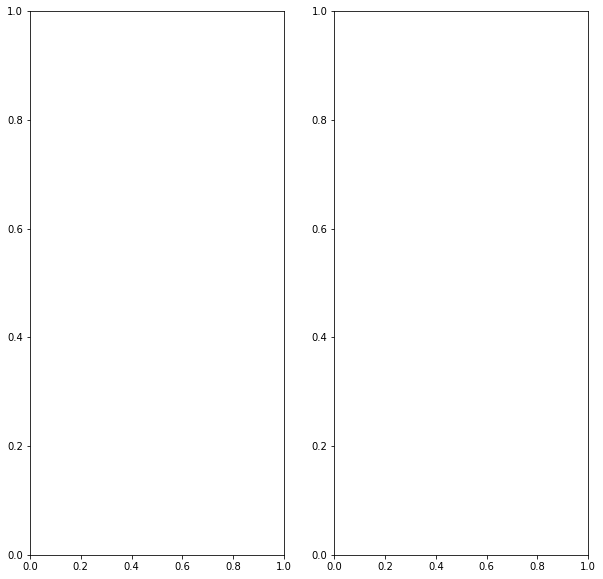

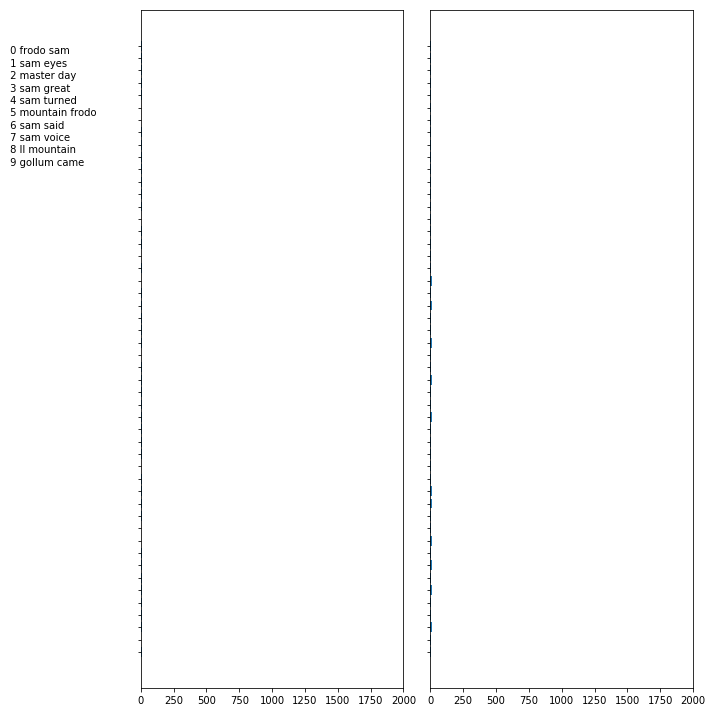

In [773]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
        for i, words in enumerate(feature_names[sorting[:, :2]])]

# two column bar chart:
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()
plt.show()

In [768]:
### 100 topics (components)
lda100 = LatentDirichletAllocation(n_components=100, learning_method="batch",
                                   max_iter=25, random_state=0)

document_topics100 = lda100.fit_transform(MountDoom)

topics = np.array([0, 1, 2, 4, 5, 12, 24])

sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]

feature_names = np.array(vect.get_feature_names())
mglearn.tools.print_topics(topics=topics, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=20)

topic 0       topic 1       topic 2       topic 4       topic 5       
--------      --------      --------      --------      --------      
sam           masster       cloud         frodo         lonely        
falling       wicked        midst         breast        paths         
master        cheats        towers        sam           dreadful      
isn           hissed        swirling      hand          unchanged     
covered       smjagol       vision        drew          hungry        
orc           increased     brief         saw           waterless     
ore           travellers    responsibilitypassed        limbs         
sword         maybe         brought       standing      hardened      
shirt         did           sense         matched       felt          
ragged        half          new           old           thrill        
add           left          eyes          strength      follow        
seemingly     relied        land          flung         road          
head  

In [769]:
print(document_topics100)

[[ 0.01  0.01  0.01 ...,  0.01  0.01  0.01]
 [ 0.01  0.01  0.01 ...,  0.01  0.01  0.01]
 [ 0.01  0.01  0.01 ...,  0.01  0.01  0.01]
 ..., 
 [ 0.01  0.01  0.01 ...,  0.01  0.01  0.01]
 [ 0.01  0.01  0.01 ...,  0.01  0.01  0.01]
 [ 0.01  0.01  0.01 ...,  0.01  0.01  0.01]]


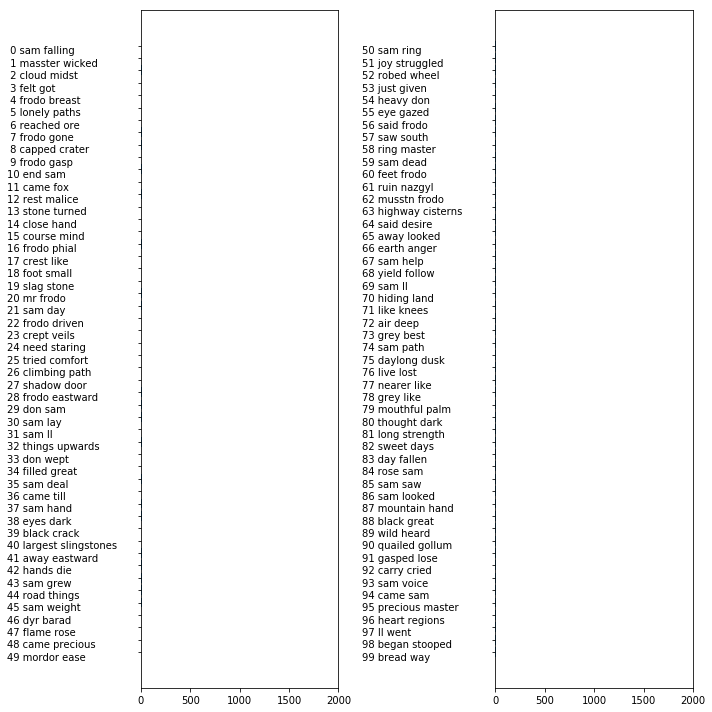

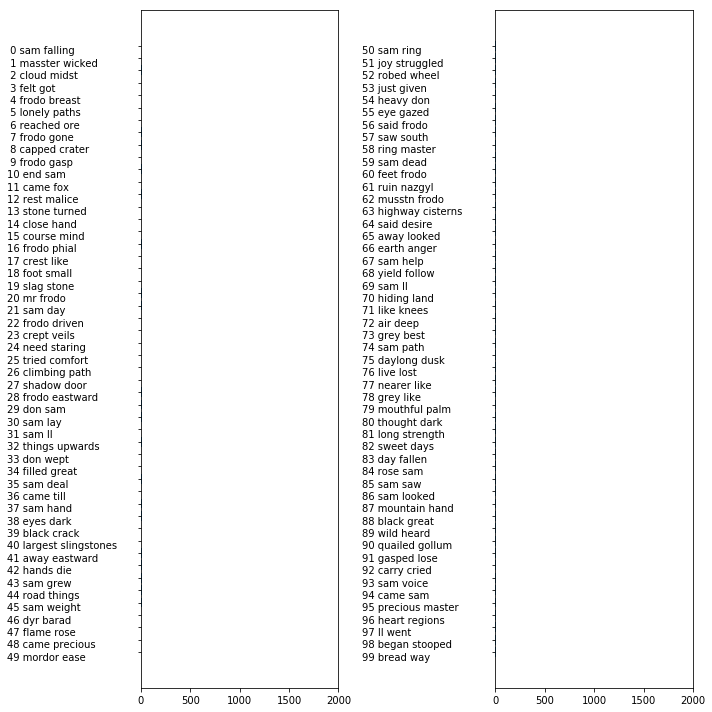

In [764]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
        for i, words in enumerate(feature_names[sorting[:, :2]])]

# two column bar chart:
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()
plt.show()

In [776]:
### Join all raw text files together

lotr_join = [' '.join(filter(str.isalpha, raw.lower().split())) for raw in
        raw_texts]


In [779]:
import lda

n_topics = 20 # number of topics
n_iter = 500 # number of iterations

# vectorizer: ignore English stopwords & words that occur less than 5 times
cvectorizer = CountVectorizer(min_df=5, stop_words='english')
cvz = cvectorizer.fit_transform(lotr_join)

# train an LDA model
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)

#lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method="batch",
#                                   max_iter=n_iter, random_state=0)

X_topics = lda_model.fit_transform(cvz)



INFO:lda:n_documents: 5
INFO:lda:vocab_size: 1679
INFO:lda:n_words: 145449
INFO:lda:n_topics: 20
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -1514925
INFO:lda:<10> log likelihood: -1208692
INFO:lda:<20> log likelihood: -1144239
INFO:lda:<30> log likelihood: -1117709
INFO:lda:<40> log likelihood: -1099715
INFO:lda:<50> log likelihood: -1089026
INFO:lda:<60> log likelihood: -1081226
INFO:lda:<70> log likelihood: -1075330
INFO:lda:<80> log likelihood: -1068515
INFO:lda:<90> log likelihood: -1065138
INFO:lda:<100> log likelihood: -1063475
INFO:lda:<110> log likelihood: -1061118
INFO:lda:<120> log likelihood: -1059835
INFO:lda:<130> log likelihood: -1057109
INFO:lda:<140> log likelihood: -1056423
INFO:lda:<150> log likelihood: -1056971
INFO:lda:<160> log likelihood: -1054376
INFO:lda:<170> log likelihood: -1054881
INFO:lda:<180> log likelihood: -1055295
INFO:lda:<190> log likelihood: -1054355
INFO:lda:<200> log likelihood: -1054331
INFO:lda:<210> log likelihood: -1054108
INFO:lda:<220

In [775]:
print(X_topics)

[[ 0.05  0.05  0.05 ...,  0.05  0.05  0.05]
 [ 0.05  0.05  0.05 ...,  0.05  0.05  0.05]
 [ 0.05  0.05  0.05 ...,  0.05  0.05  0.05]
 ..., 
 [ 0.05  0.05  0.05 ...,  0.05  0.05  0.05]
 [ 0.05  0.05  0.05 ...,  0.05  0.05  0.05]
 [ 0.05  0.05  0.05 ...,  0.05  0.05  0.05]]


In [780]:
n_top_words = 4 # number of keywords we show

topic_summaries = []
topic_word = lda_model.topic_word_  # all topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get!
    topic_summaries.append(' '.join(topic_words)) # append!

print(topic_words)
## 5 most common words per topic
print((topic_summaries))

# n =4 
## gandalf said ring felt
## dwarves forest mountain treasure

['men' 'elves' 'dwelt' 'sons']
['did days darkness turned', 'left long little hand', 'came shall come land', 'like come good way', 'dwarves soon got did', 'great king lord brought', 'old just far thought', 'great dark passed lay', 'said like gandalf shall', 'heard light end began', 'men went stood come', 'went river took elves', 'deep feet tall golden', 'said long strange does', 'came little time long', 'people son long called', 'towers ores did trees', 'know looked road away', 'far fell saw place', 'men elves dwelt sons']


In [783]:
### Run Topic modeling for every book, choose common topic words, topic summary words

## Run on every chapter
#print(negative_chapters[0])

n_topics = 20 # number of topics
n_iter = 500 # number of iterations

#print(negative_chapters[0])
#print(lotr_join[0])

negatives = [' '.join(filter(str.isalpha, chapter.lower().split())) for chapter in negative_chapters]

# vectorizer: ignore English stopwords & words that occur less than 5 times
cvectorizer = CountVectorizer(min_df=5, stop_words='english')
cvz = cvectorizer.fit_transform(newtext)

# train an LDA model
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)

#lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method="batch",
#                                   max_iter=n_iter, random_state=0)

X_topics = lda_model.fit_transform(cvz)


INFO:lda:n_documents: 9368
INFO:lda:vocab_size: 114
INFO:lda:n_words: 1029
INFO:lda:n_topics: 20
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -9827
INFO:lda:<10> log likelihood: -5840
INFO:lda:<20> log likelihood: -5754
INFO:lda:<30> log likelihood: -5817
INFO:lda:<40> log likelihood: -5885
INFO:lda:<50> log likelihood: -5833
INFO:lda:<60> log likelihood: -5833
INFO:lda:<70> log likelihood: -5849
INFO:lda:<80> log likelihood: -5795
INFO:lda:<90> log likelihood: -5862
INFO:lda:<100> log likelihood: -5799
INFO:lda:<110> log likelihood: -5898
INFO:lda:<120> log likelihood: -5744
INFO:lda:<130> log likelihood: -5740
INFO:lda:<140> log likelihood: -5792
INFO:lda:<150> log likelihood: -5821
INFO:lda:<160> log likelihood: -5727
INFO:lda:<170> log likelihood: -5871
INFO:lda:<180> log likelihood: -5860
INFO:lda:<190> log likelihood: -5760
INFO:lda:<200> log likelihood: -5819
INFO:lda:<210> log likelihood: -5710
INFO:lda:<220> log likelihood: -5893
INFO:lda:<230> log likelihood: -5826
INFO:

In [784]:
print(X_topics)

[[ 0.05  0.05  0.05 ...,  0.05  0.05  0.05]
 [ 0.05  0.05  0.05 ...,  0.05  0.05  0.05]
 [ 0.05  0.05  0.05 ...,  0.05  0.05  0.05]
 ..., 
 [ 0.05  0.05  0.05 ...,  0.05  0.05  0.05]
 [ 0.05  0.05  0.05 ...,  0.05  0.05  0.05]
 [ 0.05  0.05  0.05 ...,  0.05  0.05  0.05]]


# Word Search

In [474]:
## Calculate all frequencies

silm_freq = {}
hobbit_freq = {}
fellowship_freq = {}
twotowers_freq = {}
return_freq = {}

freq_dicts = [silm_freq, hobbit_freq, fellowship_freq, twotowers_freq, return_freq]

for i in range(len(tokenlist)):
    for word in tokenlist[i]:
        word = word.lower()
        if word not in punctuation and not word.isnumeric() and word.isalpha():
            if word in freq_dicts[i]:
                freq_dicts[i][word] += 1
            else:
                freq_dicts[i][word] = 1

entirety_dict = {}

for word in entirety:
    word = word.lower()
    if word not in punctuation and not word.isnumeric() and word.isalpha():
        if word in entirety_dict:
            entirety_dict[word] += 1
        else:
            entirety_dict[word] = 1
            

In [724]:
"""
Function that returns the frequency of a given word in each book:

Parameters - word - input word

Returns the frequency of the input word in each book.
"""

#NOTE:: For whatever reason, the words "orc" and "orcs" were converted to "ore" and "ores"
## I suppose this is the drawback of pulling 5 books off the internet


def WordSearch(word):
    word = word.lower() 
    for i in range(len(tokenlist)):
        if i == 0:
            if word in freq_dicts[i]:
                print("------------------------------------------------------")
                print("The Silmarillion:", freq_dicts[i][word], "Out of 130,115 Words")
                print("------------------------------------------------------")
            else:
                print("------------------------------------------------------")
                print("The Silmarillion: 0 Out of 130,115 Words")   
                print("------------------------------------------------------")
        if i == 1:
            if word in freq_dicts[i]:
                print("The Hobbit:", freq_dicts[i][word], "Out of 95,356 Words")
                print("------------------------------------------------------")
            else:
                print("The Hobbit: 0 Out of 95,356 Words")
                print("------------------------------------------------------")
        if i == 2:
            if word in freq_dicts[i]:
                print("The Fellowship of the Ring:", freq_dicts[i][word], "Out of 187,790 Words")
                print("------------------------------------------------------")
            else:
                print("The Fellowship of the Ring: 0 Out of 187,790 Words")
                print("------------------------------------------------------")
        if i == 3:
            if word in freq_dicts[i]:
                print("The Two Towers:", freq_dicts[i][word], "Out of 156,198 Words")
                print("------------------------------------------------------")
            else:
                print("The Two Towers: 0 Out of 156,198 Words")
                print("------------------------------------------------------")
        if i == 4:
            if word in freq_dicts[i]:
                print("The Return of the King:", freq_dicts[i][word], "Out of 137,115 Words")
                print("------------------------------------------------------")
            else:
                print("The Return of the King: 0 Out of 137,115 Words")
                print("------------------------------------------------------")
    if word in entirety_dict:
        print("Entire Corpus:", entirety_dict[word])
        print("------------------------------------------------------")
                
WordSearch("ores")


### Add entirety of text?

------------------------------------------------------
The Silmarillion: 130 Out of 130,115 Words
------------------------------------------------------
The Hobbit: 2 Out of 95,356 Words
------------------------------------------------------
The Fellowship of the Ring: 54 Out of 187,790 Words
------------------------------------------------------
The Two Towers: 220 Out of 156,198 Words
------------------------------------------------------
The Return of the King: 61 Out of 137,115 Words
------------------------------------------------------
Entire Corpus: 467
------------------------------------------------------


# Word Clouds

In [306]:
## Lists of words to go to word clouds
silm_cloud = []
hobbit_cloud = []
fellowship_cloud = []
twotowers_cloud = []
return_cloud = []

cloudlist = [silm_cloud, hobbit_cloud, fellowship_cloud, twotowers_cloud, return_cloud]

for i in range(len(tokenlist)):
    for word in tokenlist[i]:
        word=word.lower()
        if word not in punctuation and word not in stop_words and not word.isnumeric() and word.isalpha():
            if freq_dicts[i][word] > 5: ## Only words that occur 5 times or more
                cloudlist[i].append(word)

## Dataframes to send to Tableau

silm_cloud_df = pd.DataFrame(cloudlist[0], columns = ["The Silmarillion"])
hobbit_cloud_df = pd.DataFrame(cloudlist[1], columns = ["The Hobbit"])
fellowship_cloud_df = pd.DataFrame(cloudlist[2], columns = ["The Fellowship of the Ring"])
twotowers_cloud_df = pd.DataFrame(cloudlist[3], columns = ["The Two Towers"])
return_cloud_df = pd.DataFrame(cloudlist[4], columns = ["The Return of the King"])


cloud = pd.ExcelWriter('cloud.xlsx')

silm_cloud_df.to_excel(cloud, 'The Silmarillion')
hobbit_cloud_df.to_excel(cloud, 'The Hobbit')
fellowship_cloud_df.to_excel(cloud, 'Fellowship of the Rings')
twotowers_cloud_df.to_excel(cloud, 'The Two Towers')
return_cloud_df.to_excel(cloud, 'The Return of the King')

cloud.save()



In [725]:
### Negative Word Cloud Exports

negative_chapters = []
negative_tokens = []
negative_words = []
"""
A Knife in the Dark
The Departure of Boromir
The Ride of Rohirrim
The Battle of the Pelennor Fields
The Pyre of Denethor
The Black Gate Opens
Mount Doom
"""
negative_chapters.append(fellowship_chapters[14])
negative_chapters.append(twotowers_chapters[0])
negative_chapters.append(return_chapters[4])
negative_chapters.append(return_chapters[5])
negative_chapters.append(return_chapters[6])
negative_chapters.append(return_chapters[9])
negative_chapters.append(return_chapters[12])

tolkien_stop = ["men","great", "'s", "said", "went", "he", "would", "many", "one", "he", "came", "yet", "even", "shall", \
                "upon", "days", "looked", "n't", "back", "could", "'ll", "'ve", "come", "still", "gate", "'i" ]
names = ["gandalf", "merry", "pippin", "frodo", "sam", "aragorn", "faramir", "denethor", "gimli", "legolas"]
for chapter in negative_chapters:
    negative_tokens.append(nltk.word_tokenize(chapter))
  
for i in range(len(negative_tokens)):
    for word in negative_tokens[i]:
        word = word.lower()
        if word not in punctuation and word not in stop_words and not word.isnumeric()\
        and word.isalpha() and word not in tolkien_stop and word not in names:
            negative_words.append(word)

            
neg_df = pd.DataFrame(negative_words, columns = ["Negative Chapter Words"])                 
neg = pd.ExcelWriter('negative.xlsx')
neg_df.to_excel(neg, 'Sheet 1')
neg.save()

In [ ]:
### Positive Word Cloud Exports




# Testing

In [ ]:
#Working with 'glob'

path= '/Users/blaz/Desktop/LOTR/silmarillion-chapters'
silm_chapters = []

for file in sorted(glob.glob(os.path.join(path,'*.txt'))):
    print(file)
    f = open(file, 'r')
    txt = f.read()
    silm_chapters.append(txt)
    
print(len(silm_chapters))
print(silm_chapters[len(silm_chapters)-1])